In [2]:
import pickle
import numpy as np
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [3]:
loaded_dict

{'rf_entropy': {3: {'margin': {'budget': [10.0,
     20.0,
     30.0,
     40.0,
     50.0,
     60.0,
     70.0,
     80.0,
     90.0,
     100.0,
     110.0,
     120.0,
     130.0,
     140.0,
     150.0,
     160.0,
     170.0,
     180.0,
     190.0,
     200.0,
     210.0],
    'mean': [0.6548815165,
     0.7090521330000001,
     0.7607109015000001,
     0.8411848340000001,
     0.8715639810000001,
     0.897582938,
     0.9181516585000002,
     0.9322274874999998,
     0.9394786739999998,
     0.9471563985000001,
     0.9524170614999999,
     0.9571563985000002,
     0.9619431285000001,
     0.965402844,
     0.9685781979999998,
     0.9715639805,
     0.9741232219999999,
     0.9767298569999999,
     0.9786729855,
     0.9811374405000001,
     0.9826066354999998],
    'std': [0.05088825127905388,
     0.036252508823639264,
     0.043195996441153794,
     0.03303247525368846,
     0.02935007364111534,
     0.019394985747518575,
     0.01924028066416153,
     0.011030383695405722

In [14]:
learners = list(loaded_dict.keys())

In [15]:
for learner in learners[:1]:
    learner_dict = loaded_dict[learner]
    openmlids = list(learner_dict.keys())
    for openmlid in openmlids[:1]:
        query_strategies = list(learner_dict[openmlid].keys())

In [16]:
print(learners)

['rf_entropy', 'tabpfn', 'catboost']


In [17]:
print(query_strategies)

['margin', 'entropy', 'cluster_margin', 'typ_cluster', 'random']


In [18]:
print(openmlids)

[3, 6, 11, 12, 14, 15, 16, 18, 22, 23, 28, 29, 31, 32, 37, 44, 46, 50, 54, 151, 182, 188, 38, 307, 300, 458, 469, 554, 1049, 1050, 1053, 1063, 1067, 1068, 1590, 4134, 1510, 1489, 1494, 1497, 1501, 1480, 1485, 1486, 1487, 1468, 1475, 1462, 1464, 4534, 6332, 1461, 4538, 1478, 23381, 40499, 40668, 40966, 40982, 40994, 40983, 40975, 40984, 40979, 40996, 41027, 23517, 40923, 40927, 40978, 40670, 40701]


### hierarchy: learner, openmlid, qs

In [19]:
results = {}
for l in list(loaded_dict.keys())[:]:
    print(l)
    learner_dict = loaded_dict[l]
    results[l] = {}
    for oid in list(learner_dict.keys())[:]:
        results[l][oid] = {}
        oid_dict = learner_dict[oid]
        for qs in list(oid_dict.keys())[:]:
            iteration = -1
            num_iterations = len(oid_dict[qs]["mean"])
            inside_eps = False
            for it in range(num_iterations)[:]:
                current_eps = oid_dict[qs]["std_top"][it]/np.sqrt(10)
                current_top_mean = oid_dict[qs]["mean_top"][it]
                current_low_mean = oid_dict[qs]["mean_low"][it]
                if not inside_eps:
                    if current_low_mean >= current_top_mean - current_eps:
                        iteration = it
                        break
                        #inside_eps = True
                        
                #if inside_eps:
                    #print("current low ", current_low_mean)
                    #print("current top ", current_top_mean)
                    #print("current top - avg ", current_top_mean - current_eps)
                #    if current_low_mean < current_top_mean - current_eps:
                #        inside_eps = False
                #        iteration = -1              
            #if iteration == -1:
            #    print(oid)
            results[l][oid][qs] = iteration

rf_entropy
tabpfn
catboost


In [20]:
alp_stats = {}
for l in learners:
    for qs in query_strategies:
        alp_stats[(l,qs)] = {"vals":[], "no_catch_up": 0, "mean_catch_up": (0,0)} 


In [21]:
for l in learners:
    print(l)
    learner_dict = results[l]
    for oid in openmlids:
        oid_dict = learner_dict[oid]
        for qs in query_strategies:
            if qs in results[l][oid]:
                #print("JO")
                val = results[l][oid][qs]
                
                alp_stats[(l,qs)]["vals"].append(val)


rf_entropy
tabpfn
catboost


In [22]:
for key in alp_stats.keys():
    #print(key)
    print(len(alp_stats[key]["vals"]))

72
72
65
72
72
47
47
47
48
47
72
72
65
72
72


In [23]:
for key in alp_stats.keys():
    values = np.array(alp_stats[key]["vals"])
    
    no_catch_up_ids = np.argwhere(values == -1)
    catch_up_ids = np.argwhere(values != -1)
    #print("len val",len(values))
    #print(len(catch_up_ids))
    alp_stats[key]["no_catch_up"] = len(no_catch_up_ids)
    alp_stats[key]["mean_catch_up"] = len(catch_up_ids), np.mean(values[catch_up_ids])

    

In [24]:
#for key in alp_stats.keys():
#    print(key)
#    print(alp_stats[key]["no_catch_up"])
#    print(alp_stats[key]["mean_catch_up"], "\n")

## compute aubc

In [25]:
results = {}
for l in list(loaded_dict.keys())[:]:
    learner_dict = loaded_dict[l]
    results[l] = {}
    for oid in list(learner_dict.keys())[:]:
        results[l][oid] = {}
        oid_dict = learner_dict[oid]
        for qs in list(oid_dict.keys())[:]:
            iteration = -1
            num_iterations = len(oid_dict[qs]["mean"])
            budget = oid_dict[qs]["budget"]
            top = []
            low = []
            for it in range(num_iterations):
                current_top_mean = oid_dict[qs]["mean_top"][it]
                current_low_mean = oid_dict[qs]["mean_low"][it]
                top.append(current_top_mean)
                low.append(current_low_mean)
            top_aubc = np.trapz(top, budget)
            low_aubc = np.trapz(low, budget)
            total_aubc = np.trapz(np.ones(len(top)),budget)
                
            results[l][oid][qs] = {"strong_aubc": top_aubc/total_aubc, "weak_aubc":low_aubc/total_aubc}

In [26]:
results

{'rf_entropy': {3: {'margin': {'strong_aubc': 0.91975592405,
    'weak_aubc': 0.91260189575},
   'entropy': {'strong_aubc': 0.9194312799749998, 'weak_aubc': 0.913137440925},
   'cluster_margin': {'strong_aubc': 0.9250758294000001,
    'weak_aubc': 0.9152180097},
   'typ_cluster': {'strong_aubc': 0.8883459713499999,
    'weak_aubc': 0.8805639807750001},
   'random': {'strong_aubc': 0.881502369675, 'weak_aubc': 0.8809194314}},
  6: {'margin': {'strong_aubc': 0.858667830275,
    'weak_aubc': 0.8591149977750001},
   'entropy': {'strong_aubc': 0.7769773574, 'weak_aubc': 0.77291998045},
   'cluster_margin': {'strong_aubc': 0.8375129851250002,
    'weak_aubc': 0.836312692775},
   'typ_cluster': {'strong_aubc': 0.8233647135749999,
    'weak_aubc': 0.8219469243249998},
   'random': {'strong_aubc': 0.7939165723250001,
    'weak_aubc': 0.7948299790000001}},
  11: {'margin': {'strong_aubc': 0.811026570325, 'weak_aubc': 0.809963768275},
   'entropy': {'strong_aubc': 0.81323671515, 'weak_aubc': 0.80

In [27]:
alp_stats = {}
for l in learners:
    for qs in query_strategies:
        alp_stats[(l,qs)] = {"top_wins":0, "low_wins": 0, "top_aubc": [], "low_aubc": []} 

In [28]:
for l in learners:
    print(l)
    learner_dict = results[l]
    for oid in openmlids:
        oid_dict = learner_dict[oid]
        for qs in query_strategies:
            if qs in results[l][oid]:
                top_aubc = results[l][oid][qs]["strong_aubc"]
                low_aubc = results[l][oid][qs]["weak_aubc"]
                alp_stats[(l,qs)]["top_aubc"].append(top_aubc)
                alp_stats[(l,qs)]["low_aubc"].append(low_aubc)

                if top_aubc > low_aubc:
                    alp_stats[(l,qs)]["top_wins"] += 1
                else:
                    alp_stats[(l,qs)]["low_wins"] += 1
        

rf_entropy
tabpfn
catboost


In [29]:
for l in learners:
    learner_dict = results[l]
    for qs in query_strategies:
        alp_stats[(l,qs)]["top_mean"] = np.array(alp_stats[(l,qs)]["top_aubc"]).mean()
        alp_stats[(l,qs)]["low_mean"] = np.array(alp_stats[(l,qs)]["low_aubc"]).mean()

In [30]:
for l in learners:
    for qs in query_strategies:
        lqs = alp_stats[(l,qs)]
        #print((l,qs))
       # print(lqs["top_wins"])
        #print(lqs["low_wins"])
        #print("strong",lqs["top_mean"])
        #print("weak",lqs["low_mean"],"\n")

### filter out accuracies

In [31]:

strongs = {}
weaks = {}
for qs in query_strategies:
    strongs[qs] = []
    weaks[qs] = []
    
for l in list(loaded_dict.keys())[:]:
    learner_dict = loaded_dict[l]
    for oid in list(learner_dict.keys())[:]:
        oid_dict = learner_dict[oid]
        for qs in list(oid_dict.keys())[:]:
            strongs[qs].append(np.array(oid_dict[qs]['accs_iter_init']['strong']).mean())
            weaks[qs].append(np.array(oid_dict[qs]['accs_iter_init']['weak']).mean())
      

In [35]:
qs_for_figure = {"margin": "MS", "least_confident": "LC", "entropy": "ES",
                                "power_margin": "PowMS", "bald": "BALD", "power_bald": "PowBALD",
                                "max_entropy": "MaxEnt", "qbc_variance_ratio": "QBC VR",
                                "core_set": "CoreSet", "typ_cluster": "TypClu", "cluster_margin": "CluMS",
                                "weighted_cluster": "Clue", "falcun": "FALCUN", "random": "Rand"}
color_dict = {"random": "magenta", "least_confident": "rosybrown", "margin": "red",
                          "entropy": "orange", "power_margin": "brown", "bald": "tomato",
                          "power_bald": "coral", "max_entropy": "sandybrown", "qbc_variance_ratio": "peachpuff",
                          "core_set": "limegreen", "typ_cluster": "forestgreen", "cluster_margin": "mediumblue",
                          "weighted_cluster": "turquoise", "falcun": "blue"}

In [39]:
query_strategies = ['random', 'entropy', 'margin', 'typ_cluster', 'cluster_margin']

magenta
orange
red
forestgreen
mediumblue


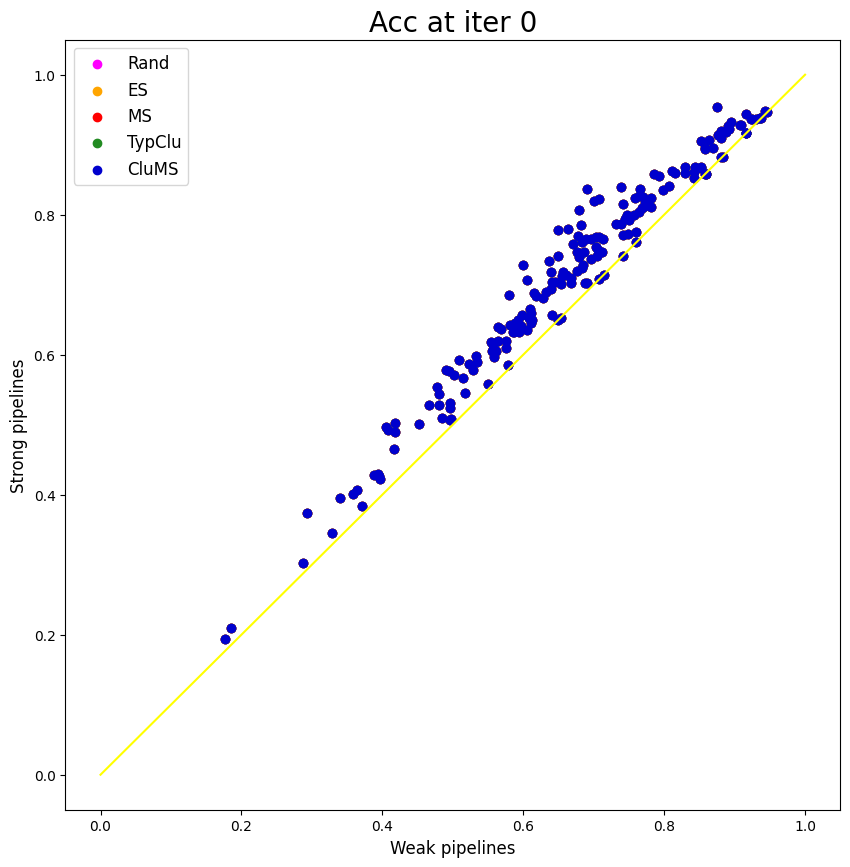

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure(figsize=(10,10))
colors = cm.rainbow(np.linspace(0, 1, len(strongs)+1))

plt.plot([0,1],[0,1], color = "yellow")

for key in query_strategies[:]:
    print(color_dict[key])
    plt.scatter(weaks[qs],strongs[qs], label=qs_for_figure[key], color=color_dict[key])

            
plt.title("Accuracies at iter 0", fontsize = 20)
plt.xlabel("Weak pipelines", fontsize = 12)
plt.ylabel("Strong pipelines", fontsize = 12)
plt.legend(fontsize=12)
plt.show()
#fig.savefig("fig.pdf", facecolor='white', transparent=True, bbox_inches='tight')


Text(0, 0.5, 'strong')

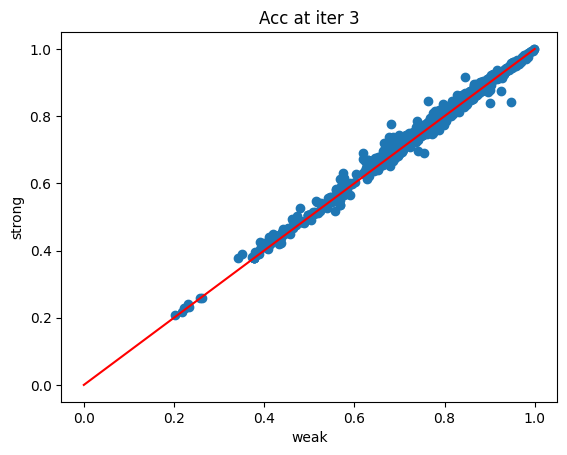

In [11]:
strongs = []
weaks = []
for l in list(loaded_dict.keys())[:]:
    learner_dict = loaded_dict[l]
    for oid in list(learner_dict.keys())[:]:
        oid_dict = learner_dict[oid]
        for qs in list(oid_dict.keys())[:]:
            #if l == "rf_entropy":
            strongs.append(np.array(oid_dict[qs]['accs_iter_3']['strong']).mean())
            weaks.append(np.array(oid_dict[qs]['accs_iter_3']['weak']).mean())

import matplotlib.pyplot as plt
plt.scatter(weaks,strongs)
plt.plot([0,1],[0,1], color = "red")
plt.title("Acc at iter 3")
plt.xlabel("weak")
plt.ylabel("strong")

Text(0, 0.5, 'strong')

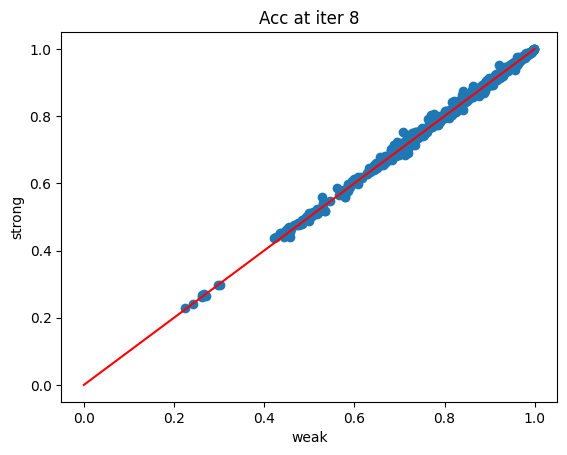

In [12]:
strongs = []
weaks = []
for l in list(loaded_dict.keys())[:]:
    learner_dict = loaded_dict[l]
    for oid in list(learner_dict.keys())[:]:
        oid_dict = learner_dict[oid]
        for qs in list(oid_dict.keys())[:]:
            if "strong" in oid_dict[qs]['accs_iter_8'].keys():
                strongs.append(np.array(oid_dict[qs]['accs_iter_8']['strong']).mean())
                weaks.append(np.array(oid_dict[qs]['accs_iter_8']['weak']).mean())
                #strongs.append(oid_dict[qs]['accs_iter_8']['strong'])
                #weaks.append(oid_dict[qs]['accs_iter_8']['weak'])
                
import matplotlib.pyplot as plt
plt.scatter(weaks,strongs)
plt.plot([0,1],[0,1], color = "red")
plt.title("Acc at iter 8")
plt.xlabel("weak")
plt.ylabel("strong")

Text(0, 0.5, 'strong')

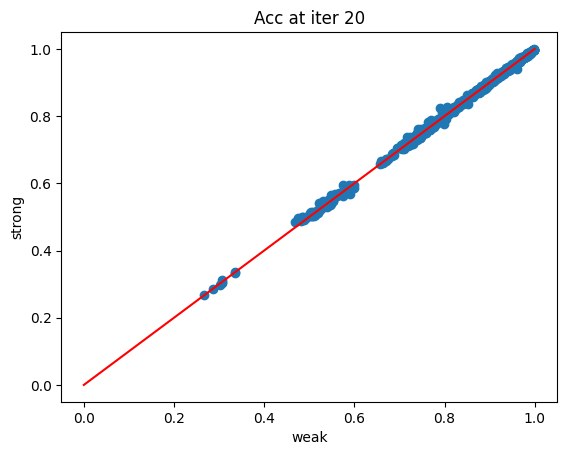

In [14]:
strongs = []
weaks = []
for l in list(loaded_dict.keys())[:]:
    learner_dict = loaded_dict[l]
    for oid in list(learner_dict.keys())[:]:
        oid_dict = learner_dict[oid]
        for qs in list(oid_dict.keys())[:]:
            #if qs == "random":
            if "strong" in oid_dict[qs]['accs_iter_20'].keys():
                strongs.append(np.array(oid_dict[qs]['accs_iter_20']['strong']).mean())
                weaks.append(np.array(oid_dict[qs]['accs_iter_20']['weak']).mean())
                #strongs.append(oid_dict[qs]['accs_iter_20']['strong'])
                #weaks.append(oid_dict[qs]['accs_iter_20']['weak'])

import matplotlib.pyplot as plt
plt.scatter(weaks,strongs)
plt.plot([0,1],[0,1], color = "red")
plt.title("Acc at iter 20")
plt.xlabel("weak")
plt.ylabel("strong")